# API assignment 

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path
Path("data").mkdir(parents=True, exist_ok=True)

## Settings

In [16]:
site  = "12451000"
start = "2021-11-12"
end   = "2021-11-19"

Path("data").mkdir(exist_ok=True)

## Site metadata

In [17]:
site = "12451000"  # Stehekin River at Stehekin, WA
start = "2021-11-12"
end   = "2021-11-19"

site_url = f"https://waterservices.usgs.gov/nwis/site/?format=rdb&sites={site}"
sites = pd.read_csv(site_url, sep="\t", comment="#", dtype=str)
sites = sites[sites["site_no"].str.fullmatch(r"\d+")].copy()  # remove "15s" row if present
print(sites[["site_no", "station_nm", "dec_lat_va", "dec_long_va", "huc_cd"]])

    site_no                      station_nm   dec_lat_va   dec_long_va  \
1  12451000  STEHEKIN RIVER AT STEHEKIN, WA  48.32958017  -120.6917668   

     huc_cd  
1  17020009  


## Discharge (00060)

In [18]:
url_q = (
    "https://waterservices.usgs.gov/nwis/iv/?format=rdb"
    f"&sites={site}&parameterCd=00060&startDT={start}&endDT={end}"
)

q_df = pd.read_csv(url_q, sep="\t", comment="#")

# Parse datetime without warnings (handles HH:MM and HH:MM:SS)
q_df["datetime"] = q_df["datetime"].astype(str).str.strip()
dt1 = pd.to_datetime(q_df["datetime"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
dt2 = pd.to_datetime(q_df["datetime"], format="%Y-%m-%d %H:%M", errors="coerce")
q_df["datetime"] = dt1.fillna(dt2)
q_df = q_df.dropna(subset=["datetime"]).copy()

# Identify value column + rename
q_valcol = [c for c in q_df.columns
            if c not in ["agency_cd","site_no","datetime","tz_cd"]
            and not c.endswith("_cd")][0]

q_df = q_df.rename(columns={q_valcol: "discharge_cfs"})
q_df["discharge_cfs"] = pd.to_numeric(q_df["discharge_cfs"], errors="coerce")

q_df = (q_df.dropna(subset=["discharge_cfs"])
            .sort_values("datetime")
            .drop_duplicates(["site_no","datetime"]))

# Peak discharge
peak_idx = q_df["discharge_cfs"].idxmax()
print("Peak discharge (cfs):", q_df.loc[peak_idx, "discharge_cfs"])
print("Peak time:", q_df.loc[peak_idx, "datetime"], q_df.loc[peak_idx, "tz_cd"])

q_df.to_csv(f"data/usgs_{site}_iv_discharge_{start}_to_{end}.csv", index=False)
print("Saved:", f"data/usgs_{site}_iv_discharge_{start}_to_{end}.csv")

Peak discharge (cfs): 14700
Peak time: 2021-11-15 02:30:00 PST
Saved: data/usgs_12451000_iv_discharge_2021-11-12_to_2021-11-19.csv


## Stage (00065)

In [19]:
url_h = (
    "https://waterservices.usgs.gov/nwis/iv/?format=rdb"
    f"&sites={site}&parameterCd=00065&startDT={start}&endDT={end}"
)
h_df = pd.read_csv(url_h, sep="\t", comment="#")

# Check if we have actual data columns (not just metadata)
h_valcols = [c for c in h_df.columns if c not in ["agency_cd","site_no","datetime","tz_cd"] and not c.endswith("_cd")]

if len(h_valcols) == 0:
    print(f"No stage data available for site {site} between {start} and {end}")
    print("Available columns:", h_df.columns.tolist())
    h_df = pd.DataFrame(columns=["datetime", "stage_ft"])  # Create empty dataframe with expected columns
else:
    h_df["datetime"] = pd.to_datetime(h_df["datetime"], errors="coerce")
    h_df = h_df.dropna(subset=["datetime"]).copy()
    
    h_valcol = h_valcols[0]
    h_df = h_df.rename(columns={h_valcol: "stage_ft"})
    h_df["stage_ft"] = pd.to_numeric(h_df["stage_ft"], errors="coerce")
    h_df = h_df.dropna(subset=["stage_ft"]).sort_values("datetime").drop_duplicates(["site_no","datetime"])
    
    h_df.to_csv(f"data/usgs_{site}_iv_stage_{start}_to_{end}.csv", index=False)
    print(f"Saved stage data: {len(h_df)} records")

Saved stage data: 768 records


C:\Users\themo\AppData\Local\Temp\ipykernel_24580\3880170058.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  h_df["datetime"] = pd.to_datetime(h_df["datetime"], errors="coerce")


## Plot

## Second Time Period (2025-12-10 to 2025-12-16)

In [20]:
start2 = "2025-12-10"
end2   = "2025-12-16"

# Discharge for second period
url_q2 = (
    "https://waterservices.usgs.gov/nwis/iv/?format=rdb"
    f"&sites={site}&parameterCd=00060&startDT={start2}&endDT={end2}"
)

q2_df = pd.read_csv(url_q2, sep="\t", comment="#")

# Parse datetime
q2_df["datetime"] = q2_df["datetime"].astype(str).str.strip()
dt1 = pd.to_datetime(q2_df["datetime"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
dt2 = pd.to_datetime(q2_df["datetime"], format="%Y-%m-%d %H:%M", errors="coerce")
q2_df["datetime"] = dt1.fillna(dt2)
q2_df = q2_df.dropna(subset=["datetime"]).copy()

# Identify value column + rename
q2_valcol = [c for c in q2_df.columns
            if c not in ["agency_cd","site_no","datetime","tz_cd"]
            and not c.endswith("_cd")][0]

q2_df = q2_df.rename(columns={q2_valcol: "discharge_cfs"})
q2_df["discharge_cfs"] = pd.to_numeric(q2_df["discharge_cfs"], errors="coerce")

q2_df = (q2_df.dropna(subset=["discharge_cfs"])
            .sort_values("datetime")
            .drop_duplicates(["site_no","datetime"]))

q2_df["period"] = "2025-12-10 to 2025-12-16"

# Stage for second period
url_h2 = (
    "https://waterservices.usgs.gov/nwis/iv/?format=rdb"
    f"&sites={site}&parameterCd=00065&startDT={start2}&endDT={end2}"
)
h2_df = pd.read_csv(url_h2, sep="\t", comment="#")

h2_valcols = [c for c in h2_df.columns if c not in ["agency_cd","site_no","datetime","tz_cd"] and not c.endswith("_cd")]

if len(h2_valcols) == 0:
    print(f"No stage data available for {start2} to {end2}")
    h2_df = pd.DataFrame(columns=["datetime", "stage_ft"])
else:
    h2_df["datetime"] = pd.to_datetime(h2_df["datetime"], errors="coerce")
    h2_df = h2_df.dropna(subset=["datetime"]).copy()
    
    h2_valcol = h2_valcols[0]
    h2_df = h2_df.rename(columns={h2_valcol: "stage_ft"})
    h2_df["stage_ft"] = pd.to_numeric(h2_df["stage_ft"], errors="coerce")
    h2_df = h2_df.dropna(subset=["stage_ft"]).sort_values("datetime").drop_duplicates(["site_no","datetime"])

print(f"Period 2 discharge records: {len(q2_df)}")
print(f"Period 2 stage records: {len(h2_df)}")


Period 2 discharge records: 672
Period 2 stage records: 672


C:\Users\themo\AppData\Local\Temp\ipykernel_24580\3864162579.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  h2_df["datetime"] = pd.to_datetime(h2_df["datetime"], errors="coerce")


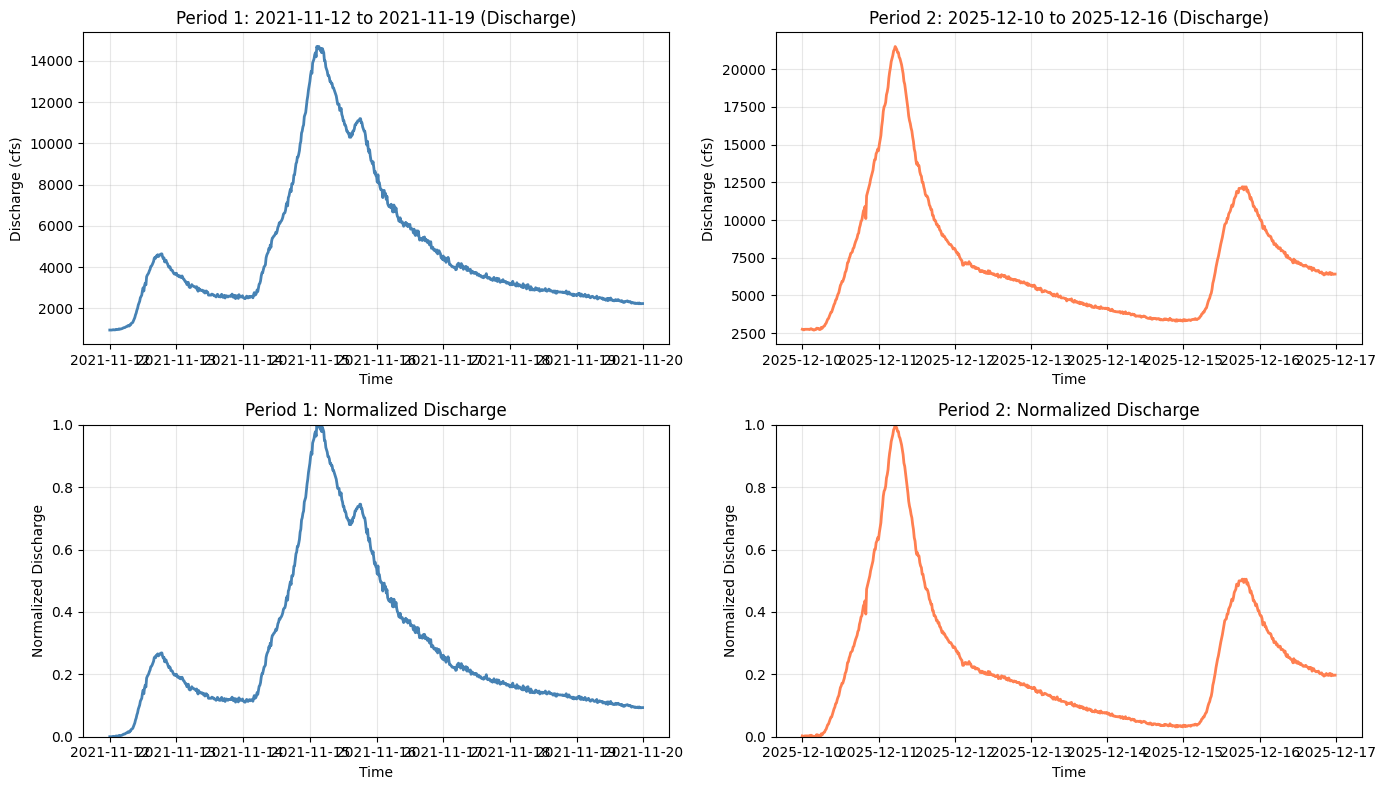


Comparative Summary:
Period 1 (2021-11-12 to 2021-11-19): 768 discharge records
  Min discharge: 945.00 cfs
  Max discharge: 14700.00 cfs
  Mean discharge: 4823.23 cfs

Period 2 (2025-12-10 to 2025-12-16): 672 discharge records
  Min discharge: 2710.00 cfs
  Max discharge: 21500.00 cfs
  Mean discharge: 7298.12 cfs


In [22]:
# Add period labels to first dataset
q_df["period"] = "2021-11-12 to 2021-11-19"

# Get period 1 and period 2 data separately
period1_data = q_df[["datetime", "discharge_cfs"]].copy()
period2_data = q2_df[["datetime", "discharge_cfs"]].copy()

# Create side-by-side comparison plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Period 1 - Raw Discharge
axes[0, 0].plot(period1_data["datetime"], period1_data["discharge_cfs"], color='steelblue', linewidth=2)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Discharge (cfs)")
axes[0, 0].set_title("Period 1: 2021-11-12 to 2021-11-19 (Discharge)")
axes[0, 0].grid(True, alpha=0.3)

# Period 2 - Raw Discharge
axes[0, 1].plot(period2_data["datetime"], period2_data["discharge_cfs"], color='coral', linewidth=2)
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("Discharge (cfs)")
axes[0, 1].set_title("Period 2: 2025-12-10 to 2025-12-16 (Discharge)")
axes[0, 1].grid(True, alpha=0.3)

# Period 1 - Normalized Discharge
period1_norm = (period1_data["discharge_cfs"] - period1_data["discharge_cfs"].min()) / (period1_data["discharge_cfs"].max() - period1_data["discharge_cfs"].min())
axes[1, 0].plot(period1_data["datetime"], period1_norm, color='steelblue', linewidth=2)
axes[1, 0].set_xlabel("Time")
axes[1, 0].set_ylabel("Normalized Discharge")
axes[1, 0].set_title("Period 1: Normalized Discharge")
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_ylim([0, 1])

# Period 2 - Normalized Discharge
period2_norm = (period2_data["discharge_cfs"] - period2_data["discharge_cfs"].min()) / (period2_data["discharge_cfs"].max() - period2_data["discharge_cfs"].min())
axes[1, 1].plot(period2_data["datetime"], period2_norm, color='coral', linewidth=2)
axes[1, 1].set_xlabel("Time")
axes[1, 1].set_ylabel("Normalized Discharge")
axes[1, 1].set_title("Period 2: Normalized Discharge")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\nComparative Summary:")
print(f"Period 1 (2021-11-12 to 2021-11-19): {len(q_df)} discharge records")
print(f"  Min discharge: {period1_data['discharge_cfs'].min():.2f} cfs")
print(f"  Max discharge: {period1_data['discharge_cfs'].max():.2f} cfs")
print(f"  Mean discharge: {period1_data['discharge_cfs'].mean():.2f} cfs")
print(f"\nPeriod 2 (2025-12-10 to 2025-12-16): {len(q2_df)} discharge records")
print(f"  Min discharge: {period2_data['discharge_cfs'].min():.2f} cfs")
print(f"  Max discharge: {period2_data['discharge_cfs'].max():.2f} cfs")
print(f"  Mean discharge: {period2_data['discharge_cfs'].mean():.2f} cfs")